# Imports.

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import regularizers

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from random import randrange

from sklearn import svm, metrics
from sklearn.model_selection import train_test_split
from skimage.util import random_noise

import cv2
import gc
from scipy.ndimage.filters import gaussian_filter
from PIL import Image, ImageDraw
from skimage.draw import line_aa


# Load The Data.

# 1 - Reconstruct Mnist Images.

In [7]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Explore Our Data.

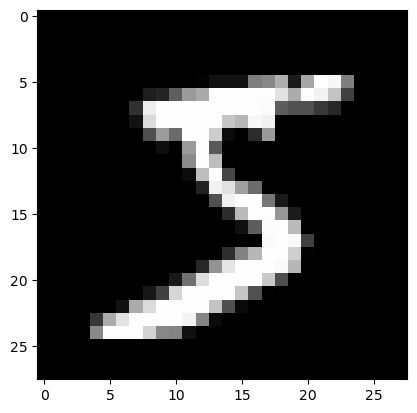

In [8]:
plt.imshow(X_train[0], cmap="gray")
plt.show()

In [9]:
np.max(X_train[0]), np.min(X_train[0])

(255, 0)

In [10]:
# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0

In [11]:
np.max(X_train[0]), np.min(X_train[0])

(1.0, 0.0)

In [12]:
X_train.shape

(60000, 28, 28)

In [13]:
X_train.shape[0], X_train.shape[1], X_train.shape[2]

(60000, 28, 28)

In [14]:
# Reshape them to the approprate shape
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

In [15]:
X_train.shape, X_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [5]:
def cae_model(n_filters=64, kernel_size=2):
    inputs = layers.Input(shape=(28, 28, 1))

    # Encoder
    encoder_1 = layers.Conv2D(filters=n_filters, kernel_size=kernel_size, activation="relu", padding="same")(inputs)
    encoder_2 = layers.MaxPooling2D(pool_size=2, padding="valid")(encoder_1)
    encoder_3 = layers.Conv2D(filters=n_filters, kernel_size=kernel_size, activation="relu", padding="same")(encoder_2)
    encoded = layers.MaxPooling2D(pool_size=2, padding="valid")(encoder_3)


    # Decoder
    decoder_1 = layers.Conv2DTranspose(filters=n_filters,
                                       kernel_size=kernel_size,
                                       strides=2,
                                       activation="relu",
                                       padding="same",)(encoded)

    decoded = layers.Conv2DTranspose(filters=n_filters,
                                     kernel_size=kernel_size,
                                     strides=2,
                                     activation="relu",
                                     padding="same",)(decoder_1)

    outputs = layers.Conv2D(filters=1, kernel_size=3, activation="sigmoid", padding="same" )(decoded)
    model = Model(inputs, outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy")
    model.summary()
    
    return encoded, model

In [6]:
compressed_version , cae_model = cae_model(n_filters=32)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 32)       4128  

In [71]:
%%time
callback_1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
batch_size = 128
cae_history = cae_model.fit(X_train,
                            X_train,
                            epochs=5,
                            validation_data=(X_test, X_test),
                            batch_size=batch_size,
                            shuffle=True,
                            callbacks=[callback_1] )

Epoch 1/10
469/469 [==============================] - 106s 214ms/step - loss: 0.1548 - val_loss: 0.0799
Epoch 2/10
469/469 [==============================] - 91s 194ms/step - loss: 0.0774 - val_loss: 0.0741
Epoch 3/10
469/469 [==============================] - 92s 196ms/step - loss: 0.0736 - val_loss: 0.0718
Epoch 4/10
469/469 [==============================] - 92s 197ms/step - loss: 0.0717 - val_loss: 0.0704
Epoch 5/10
469/469 [==============================] - 91s 193ms/step - loss: 0.0705 - val_loss: 0.0694
Epoch 6/10
469/469 [==============================] - 94s 201ms/step - loss: 0.0697 - val_loss: 0.0687
Epoch 7/10
469/469 [==============================] - 93s 198ms/step - loss: 0.0690 - val_loss: 0.0683
Epoch 8/10
469/469 [==============================] - 95s 202ms/step - loss: 0.0686 - val_loss: 0.0680
Epoch 9/10
469/469 [==============================] - 95s 203ms/step - loss: 0.0682 - val_loss: 0.0675
Epoch 10/10
469/469 [==============================] - 88s 188ms/step - 

In [12]:
#cae_model.save('cae_model.h5')
#del cae_model
#gc.collect()
cae_model = load_model('cae_model.h5')

# The Display Function.

In [16]:
def display_results(predictions, original_test_data, n=5):
    preds = []
    data = []
    # choose some samples to plot
    for i in range(n):
        random_index = randrange(len(predictions))
        preds.append(predictions[random_index])
        data.append(original_test_data[random_index])

    print("########################################################################################")
    print("#####################--First Original Images then Predected Ones--######################")
    print("########################################################################################")
    # create figure
    fig = plt.figure(figsize=(10, 2))

    rows = 2
    columns = n
    k = 0
    entire_set = n * 2
    for i in range(entire_set):
        if i > n - 1:
            k = n
        
        # Adds a subplot at the i-th position
        fig.add_subplot(rows, columns, i + 1)
        x = data[i - k]
        
        if i > n - 1:
            x = preds[i - n]
        
        plt.imshow(x, cmap='gray')
        plt.axis("off")

# Plot the Original Data and the Predicted Ones.

313/313 [==============================] - 8s 16ms/step
########################################################################################
#####################--First Original Images then Predected Ones--######################
########################################################################################


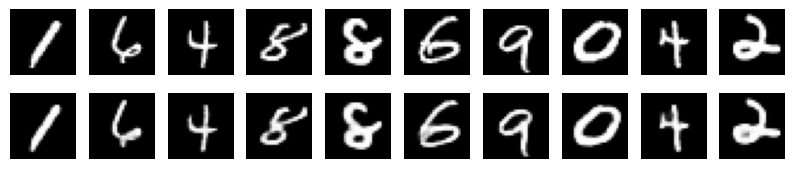

In [14]:
predictions = cae_model.predict(X_test)
display_results(predictions, X_test, n=10)

# 2 - Using The Latent Space Of CAE To Classify The Data Using SVM.

# In Progress ...

In [3]:
def model_2(n_filters=64, kernel_size=2):
    
    inputs = layers.Input(shape=(28, 28, 1))
    # Encoder
    encoder_1 = layers.Conv2D(filters=n_filters, kernel_size=kernel_size, activation="relu", padding="same")(inputs)
    encoder_2 = layers.MaxPooling2D(pool_size=2, padding="valid")(encoder_1)
    encoder_3 = layers.Conv2D(filters=n_filters, kernel_size=kernel_size, activation="relu", padding="same")(encoder_2)
    encoded = layers.MaxPooling2D(pool_size=2, padding="valid")(encoder_3)


    encoder_model = Model(inputs, encoded)
    # Decoder
    decoder_1 = layers.Conv2DTranspose(filters=n_filters,
                                       kernel_size=kernel_size,
                                       strides=2,
                                       activation="relu",
                                       padding="same",)(encoded)

    decoded = layers.Conv2DTranspose(filters=n_filters,
                                     kernel_size=kernel_size,
                                     strides=2,
                                     activation="relu",
                                     padding="same",)(decoder_1)

    outputs = layers.Conv2D(filters=1, kernel_size=3, activation="sigmoid", padding="same" )(decoded)
    
    decoder_model = Model(encoded, outputs)
    
    model = Model(inputs, outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy")
    model.summary()
    
    return encoder_model, decoder_model, model

In [4]:
_, _, cae_model_2 = model_2(n_filters=32)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 32)       4128

In [78]:
%%time
callback_1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
batch_size = 128
model_2_history = cae_model_2.fit(X_train,
                                  X_train,
                                  epochs=5,
                                  validation_data=(X_test, X_test),
                                  batch_size=batch_size,
                                  shuffle=True,
                                  callbacks=[callback_1] )

Epoch 1/5
469/469 [==============================] - 108s 226ms/step - loss: 0.1493 - val_loss: 0.0795
Epoch 2/5
469/469 [==============================] - 100s 213ms/step - loss: 0.0769 - val_loss: 0.0738
Epoch 3/5
469/469 [==============================] - 86s 183ms/step - loss: 0.0733 - val_loss: 0.0716
Epoch 4/5
469/469 [==============================] - 78s 166ms/step - loss: 0.0716 - val_loss: 0.0704
Epoch 5/5
469/469 [==============================] - 78s 165ms/step - loss: 0.0705 - val_loss: 0.0697
Wall time: 7min 29s


In [15]:
#cae_model_2.save('cae_model_2.h5')
#del cae_model_2
#gc.collect()
cae_model_2 = load_model('cae_model_2.h5')

313/313 [==============================] - 5s 17ms/step
########################################################################################
#####################--First Original Images then Predected Ones--######################
########################################################################################


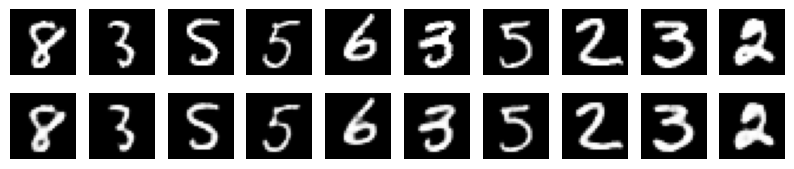

In [16]:
predictions_2 = cae_model_2.predict(X_test)
display_results(predictions_2, X_test, n=10)

In [ ]:
encoder_model, decoder_model, my_model_2 = model_2(n_filters=32)

In [17]:
#encoder_model.save('encoder_model.h5')
encoder_model = load_model('encoder_model.h5')
#decoder_model.save('decoder_model.h5')
decoder_model = load_model('decoder_model.h5')

In [18]:
compressed_imgs = encoder_model.predict(X_test)

313/313 [==============================] - 2s 5ms/step


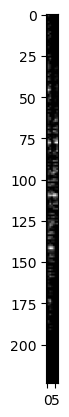

In [19]:
new_img = compressed_imgs[0].reshape((7, 7 * 32)).T
plt.imshow(new_img, cmap = 'gray')
plt.show()

In [20]:
decompressed_imgs = decoder_model.predict(compressed_imgs)

313/313 [==============================] - 4s 14ms/step


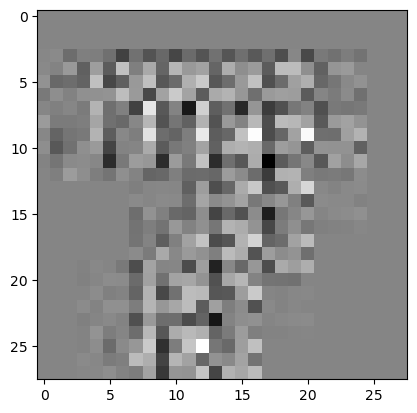

In [21]:
plt.imshow(decompressed_imgs[0], cmap = 'gray')
plt.show()

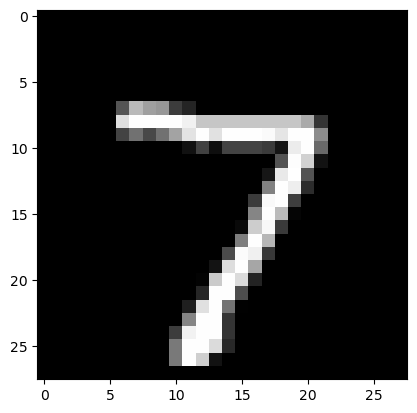

In [22]:
plt.imshow(X_test[0], cmap = 'gray')
plt.show()

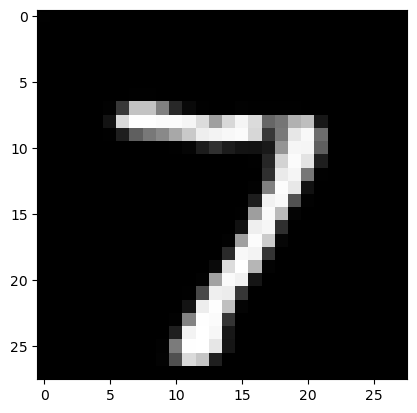

In [23]:
plt.imshow(predictions_2[0], cmap='gray')
plt.show()

# SVM

In [24]:
latenet_space_train = encoder_model.predict(X_train)
latenet_space_test = encoder_model.predict(X_test)

313/313 [==============================] - 7s 5ms/step


In [25]:
nsamples, nx, ny, nz = latenet_space_train.shape
d2_latenet_space_train = latenet_space_train.reshape((nsamples,nx*ny*nz))

nsamples, nx, ny, nz = latenet_space_test.shape
d2_latenet_space_test = latenet_space_test.reshape((nsamples,nx*ny*nz))

In [26]:
d2_latenet_space_train.shape , d2_latenet_space_test.shape

((60000, 1568), (10000, 1568))

In [27]:
y_train.shape

(60000,)

In [28]:
%%time
clf = svm.SVC()
clf.fit(d2_latenet_space_train, y_train)

Wall time: 6min 33s


SVC()

In [29]:
predicted = clf.predict(d2_latenet_space_test)

In [30]:
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.97      0.98      0.98      1010
           4       0.99      0.98      0.99       982
           5       0.98      0.98      0.98       892
           6       0.99      0.98      0.99       958
           7       0.98      0.97      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



Confusion matrix:
[[ 974    0    1    1    0    1    2    1    0    0]
 [   0 1129    2    0    0    1    3    0    0    0]
 [   6    1 1011    2    1    0    1    6    4    0]
 [   0    0    3  991    0    2    0    6    8    0]
 [   0    0    3    0  963    0    1    1    2   12]
 [   3    0    1   10    0  870    4    0    4    0]
 [   5    2    1    0    1    5  942    0    2    0]
 [   0    5    7    1    3    0    0 1002    1    9]
 [   3    0    1    6    1    5    0    2  951    5]
 [   4    3    2    9    3    2    0    4    2  980]]


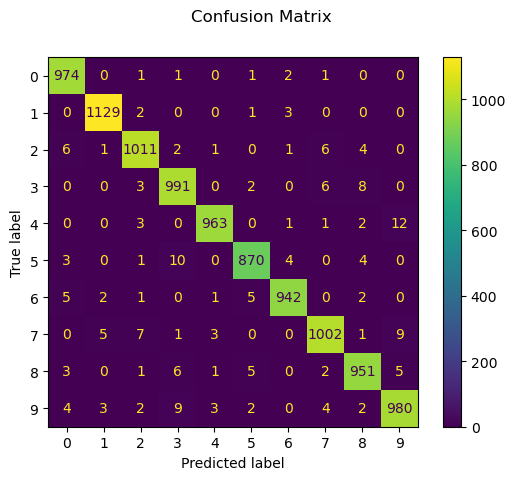

In [31]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

# A Denoising AutoEncoder to denoise / deblur / paint

In [32]:
def noise(arrays):
    imgs = arrays.copy()
    new_img = []
    for img in imgs:
        noise_factor = 0.3
        normal_dist = np.random.normal(loc=0.0, scale=1.0, size=img.shape)
        noisy_array = img + noise_factor * normal_dist
        noisy_array = np.clip(noisy_array, 0.0, 1.0)
        new_img.append(noisy_array)
    return np.array(new_img)

In [33]:
%%time
noisy_X_train = noise(X_train)
noisy_X_test = noise(X_test)

Wall time: 7.48 s


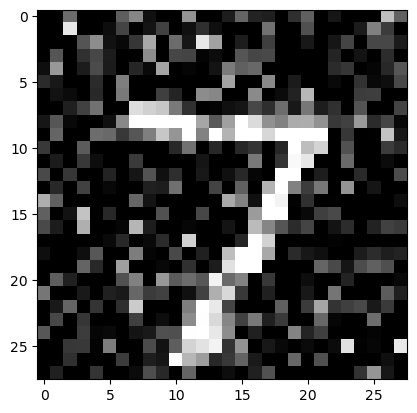

In [34]:
plt.imshow(noisy_X_test[0], cmap='gray')

In [35]:
def make_blure(arrays, sigma=2):
    imgs = arrays.copy()
    new_img = []
    for img in imgs:
        blurred = gaussian_filter(img, sigma=sigma)
        new_img.append(blurred)
    return np.array(new_img)

In [36]:
%%time
blurred_X_train = make_blure(X_train)
blurred_X_test = make_blure(X_test)

Wall time: 11.2 s


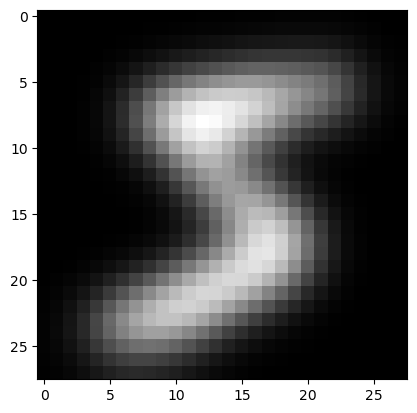

In [37]:
plt.imshow(blurred_X_train[0], cmap='gray')

In [17]:
def make_line(imgs):
    images = imgs.copy()
    new_images = imgs.copy()
    n = len(images)
    points = []
    for i in range(n):
        pnt = np.random.randint(0,27,size=(4))
        points.append(pnt)   
    
    for i in range(n):
        row, col, val = line_aa(points[i][0], points[i][1], points[i][2], points[i][3])
        val = val.reshape(val.shape[0],1)
        images[i][row, col] =  val
        new_images[i] = new_images[i] + images[i] 
    return new_images

In [20]:
%%time
painted_X_train = make_line(X_train)
painted_X_test = make_line(X_test)

Wall time: 2.51 s


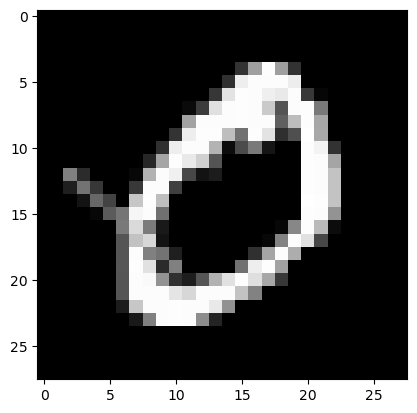

In [21]:
plt.imshow(painted_X_train[1], cmap='gray')

# Training the Model for Denoising/Debluring and Deinpainting.

## Denoising.

In [109]:
_, _, cae_model_denoise = model_2(n_filters=32)

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 28, 28, 32)        160       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 14, 14, 32)        4128      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 7, 7, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_transpose_16 (Conv2D  (None, 14, 14, 32)       412

In [110]:
%%time
callback_1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
batch_size = 128
model_denoise_history = cae_model_denoise.fit(noisy_X_train,
                                              X_train,
                                              epochs=5,
                                              validation_data=(noisy_X_test, X_test),
                                              batch_size=batch_size,
                                              shuffle=True,
                                              callbacks=[callback_1] )

Epoch 1/5
938/938 [==============================] - 99s 96ms/step - loss: 0.1567 - val_loss: 0.0968
Epoch 2/5
938/938 [==============================] - 88s 94ms/step - loss: 0.0935 - val_loss: 0.0899
Epoch 3/5
938/938 [==============================] - 92s 98ms/step - loss: 0.0895 - val_loss: 0.0877
Epoch 4/5
938/938 [==============================] - 104s 111ms/step - loss: 0.0877 - val_loss: 0.0862
Epoch 5/5
938/938 [==============================] - 92s 98ms/step - loss: 0.0866 - val_loss: 0.0855
Wall time: 8min 4s


In [41]:
#cae_model_denoise.save('cae_model_denoise.h5')
#del cae_model_denoise
#gc.collect()
cae_model_denoise = load_model('cae_model_denoise.h5')

In [42]:
predictions_noisy = cae_model_denoise.predict(noisy_X_test)

313/313 [==============================] - 13s 17ms/step


########################################################################################
#####################--First Original Images then Predected Ones--######################
########################################################################################


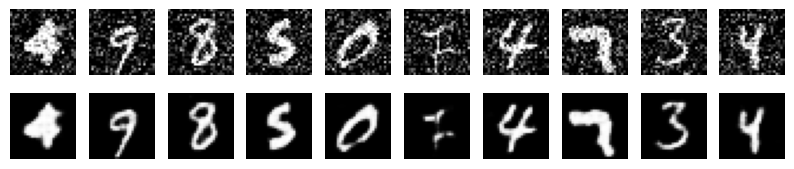

In [43]:
display_results(predictions_noisy, noisy_X_test, n=10)

# Debluring.

In [123]:
_, _, cae_model_deblur = model_2(n_filters=32)

Model: "model_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_33 (Conv2D)          (None, 28, 28, 32)        160       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 14, 14, 32)        4128      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 7, 7, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_transpose_22 (Conv2D  (None, 14, 14, 32)       412

In [124]:
%%time
callback_1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
batch_size = 128
model_deblur_history = cae_model_deblur.fit(blurred_X_train,
                                              X_train,
                                              epochs=5,
                                              validation_data=(blurred_X_test, X_test),
                                              batch_size=batch_size,
                                              shuffle=True,
                                              callbacks=[callback_1] )

Epoch 1/5
469/469 [==============================] - 82s 172ms/step - loss: 0.2009 - val_loss: 0.1080
Epoch 2/5
469/469 [==============================] - 79s 169ms/step - loss: 0.1037 - val_loss: 0.0997
Epoch 3/5
469/469 [==============================] - 82s 175ms/step - loss: 0.0977 - val_loss: 0.0941
Epoch 4/5
469/469 [==============================] - 81s 174ms/step - loss: 0.0932 - val_loss: 0.0905
Epoch 5/5
469/469 [==============================] - 79s 169ms/step - loss: 0.0901 - val_loss: 0.0879
Wall time: 6min 45s


In [44]:
#cae_model_deblur.save('cae_model_deblur.h5')
#del cae_model_deblur
#gc.collect()
cae_model_deblur = load_model('cae_model_deblur.h5')

In [45]:
predictions_blurry = cae_model_deblur.predict(blurred_X_test)

313/313 [==============================] - 5s 14ms/step


########################################################################################
#####################--First Original Images then Predected Ones--######################
########################################################################################


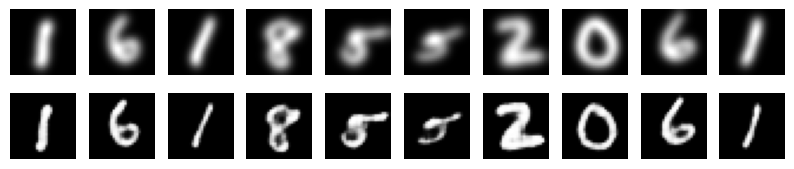

In [46]:
display_results(predictions_blurry, blurred_X_test, n=10)

# Inpaining.

In [128]:
_, _, cae_model_depaint = model_2(n_filters=32)

Model: "model_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_36 (Conv2D)          (None, 28, 28, 32)        160       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 14, 14, 32)        4128      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 7, 7, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_transpose_24 (Conv2D  (None, 14, 14, 32)       412

In [129]:
%%time
callback_1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
batch_size = 128
model_depaint_history = cae_model_depaint.fit(painted_X_train,
                                              X_train,
                                              epochs=5,
                                              validation_data=(painted_X_test, X_test),
                                              batch_size=batch_size,
                                              shuffle=True,
                                              callbacks=[callback_1] )

Epoch 1/5
469/469 [==============================] - 80s 167ms/step - loss: 0.1485 - val_loss: 0.0808
Epoch 2/5
469/469 [==============================] - 83s 178ms/step - loss: 0.0788 - val_loss: 0.0760
Epoch 3/5
469/469 [==============================] - 79s 168ms/step - loss: 0.0756 - val_loss: 0.0738
Epoch 4/5
469/469 [==============================] - 79s 168ms/step - loss: 0.0738 - val_loss: 0.0727
Epoch 5/5
469/469 [==============================] - 79s 168ms/step - loss: 0.0727 - val_loss: 0.0715
Wall time: 6min 40s


In [47]:
#cae_model_depaint.save('cae_model_depaint.h5')
#del cae_model_depaint
#gc.collect()
cae_model_depaint = load_model('cae_model_depaint.h5')

In [48]:
predictions_depainted = cae_model_depaint.predict(painted_X_test)

313/313 [==============================] - 5s 15ms/step


########################################################################################
#####################--First Original Images then Predected Ones--######################
########################################################################################


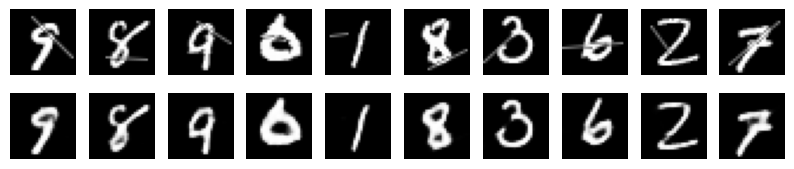

In [49]:
display_results(predictions_depainted, painted_X_test, n=10)

# Recommender System.

In [165]:
#np.random.seed(777)
df_1 = pd.DataFrame(np.random.randint(1,5,size=(50_000, 10)) )
df_1.head()

,0,1,2,3,4,5,6,7,8,9
0,3,4,3,3,3,4,4,2,4,1
1,2,4,1,2,1,2,3,1,1,1
2,1,2,1,3,4,3,2,4,3,4
3,3,3,2,4,3,1,1,4,4,1
4,2,1,1,1,1,1,3,4,1,1


In [166]:
def make_correlation_to_df_1(df):
    df1 = df.copy()
    
    for i in range(df1.shape[0]):
        # corr 0 and 9
        if(df1[0][i] == 3 or df1[0][i] == 4):
            df1[9][i] = 4
            
        # corr 1 and 5 and 7
        if(df1[1][i] == 3 or df1[1][i] == 4):
            df1[5][i] = 4
            df1[7][i] = 3
            
        # corr 2 and 7 and 0 
        if(df1[2][i] == 3 or df1[2][i] == 4):
            df1[7][i] = 4
            df1[0][i] = 3
             
        # corr 3 and 8
        if(df1[3][i] == 3 or df1[3][i] == 4):
            df1[8][i] = 4
        # corr 4 and 6
        if(df1[4][i] == 3 or df1[4][i] == 4):
            df1[6][i] = 4
            
    return df1

In [167]:
%%time
df_1 = make_correlation_to_df_1(df_1)
df_1.corr()

Wall time: 17 s


,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.003765,0.273454,0.001456,0.003273,-0.002387,0.004793,0.223353,0.002018,0.415718
1,0.003765,1.000000,-0.000416,-0.005047,0.000529,0.618947,0.004686,0.133110,-0.007003,0.002014
2,0.273454,-0.000416,1.000000,-0.004035,-0.006006,-0.005029,-0.001544,0.653666,-0.001774,-0.000749
3,0.001456,-0.005047,-0.004035,1.000000,-0.006982,-0.004136,-0.006053,-0.004708,0.613284,0.003669
4,0.003273,0.000529,-0.006006,-0.006982,1.000000,-0.003333,0.613512,0.000879,-0.004003,0.005034
5,-0.002387,0.618947,-0.005029,-0.004136,-0.003333,1.000000,-0.003149,0.098339,-0.006924,-0.002703
6,0.004793,0.004686,-0.001544,-0.006053,0.613512,-0.003149,1.000000,-0.000645,-0.006405,0.001303
7,0.223353,0.133110,0.653666,-0.004708,0.000879,0.098339,-0.000645,1.000000,0.001959,-0.001833
8,0.002018,-0.007003,-0.001774,0.613284,-0.004003,-0.006924,-0.006405,0.001959,1.000000,0.003552
9,0.415718,0.002014,-0.000749,0.003669,0.005034,-0.002703,0.001303,-0.001833,0.003552,1.000000


In [168]:
df_train_1, df_test_1 = train_test_split(df_1, test_size=0.33, random_state=42)

In [169]:
df_train.corr()

,0,1,2,3,4,5,6,7,8,9
0,1.000000,-0.000611,0.271671,0.003572,-0.001731,0.004516,0.000265,0.217628,0.006184,0.653279
1,-0.000611,1.000000,0.006327,0.000365,-0.002212,0.615598,0.002414,0.133850,-0.004092,-0.004601
2,0.271671,0.006327,1.000000,0.000814,0.002780,-0.002671,0.002465,0.649861,0.006628,0.388318
3,0.003572,0.000365,0.000814,1.000000,0.010599,-0.001354,0.003726,0.011373,0.620102,0.001517
4,-0.001731,-0.002212,0.002780,0.010599,1.000000,0.000658,0.613332,0.000782,0.006730,-0.007242
5,0.004516,0.615598,-0.002671,-0.001354,0.000658,1.000000,0.006630,0.093165,-0.008445,-0.003217
6,0.000265,0.002414,0.002465,0.003726,0.613332,0.006630,1.000000,0.005066,0.002831,-0.003069
7,0.217628,0.133850,0.649861,0.011373,0.000782,0.093165,0.005066,1.000000,0.011178,0.314637
8,0.006184,-0.004092,0.006628,0.620102,0.006730,-0.008445,0.002831,0.011178,1.000000,0.004591
9,0.653279,-0.004601,0.388318,0.001517,-0.007242,-0.003217,-0.003069,0.314637,0.004591,1.000000


In [170]:
def make_noise_to_df_1(df):
    df1 = df.copy()
    for _ in range(df1.shape[1]//2):
        for i in range(df1.shape[0]):
            probability = np.random.rand(1)
            rate = np.random.randint(low=0, high=df1.shape[1]-1, size=(1))     
            if(probability>0.7):
                df1[rate[0]][i] = 0
    return df1

In [171]:
%%time
df1_train_1 = make_noise_to_df_1(df_train_1)
df1_test_1 = make_noise_to_df_1(df_test_1)

Wall time: 28.2 s


## Data Normalization

In [200]:
df_train_1 = df_train_1/4
df1_train_1 = df1_train_1/4

df_test_1 = df_test_1/4
df1_test_1 = df1_test_1/4

In [208]:
def recommender_system_model_1():   
    inputs = layers.Input(shape=(10,))
    
    encoded = layers.Dense(units=128, activation='relu')(inputs)
  
    #encoded = layers.BatchNormalization()(encoded)
    encoded = layers.Dense(units=64, activation='relu')(encoded)
    #encoded = layers.BatchNormalization()(encoded)

    encoded = layers.Dense(units=32, activation='relu')(encoded)
    
    #encoded = layers.BatchNormalization()(encoded)
    decoded = layers.Dense(units=64, activation='relu')(encoded)
    
    #decoded = layers.BatchNormalization()(decoded)
    
    decoded = layers.Dense(units=32, activation='relu')(decoded)
    
    #decoded = layers.BatchNormalization()(decoded)
    
    outputs = layers.Dense(units=10, activation='sigmoid')(decoded)
    
    model = Model(inputs, outputs)
    #binary_crossentropy
    #tf.keras.losses.CategoricalCrossentropy()
    model.compile(optimizer="adam", loss='binary_crossentropy' )
    model.summary()
    
    return  model

In [209]:
recommender_system_model_1 = recommender_system_model_1()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 10)]              0         
                                                                 
 dense_108 (Dense)           (None, 128)               1408      
                                                                 
 dense_109 (Dense)           (None, 64)                8256      
                                                                 
 dense_110 (Dense)           (None, 32)                2080      
                                                                 
 dense_111 (Dense)           (None, 64)                2112      
                                                                 
 dense_112 (Dense)           (None, 32)                2080      
                                                                 
 dense_113 (Dense)           (None, 10)                330

In [210]:
%%time
callback_1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
batch_size = 128
recommender_system_model_history = recommender_system_model_1.fit(df1_train_1,
                                                                df_train_1,
                                                                epochs=50,
                                                                validation_data=(df1_test_1, df_test_1),
                                                                batch_size=batch_size,
                                                                shuffle=True,
                                                                callbacks=[callback_1] )

Epoch 1/50
262/262 [==============================] - 2s 4ms/step - loss: 0.4902 - val_loss: 0.4081
Epoch 2/50
262/262 [==============================] - 1s 3ms/step - loss: 0.4046 - val_loss: 0.3801
Epoch 3/50
262/262 [==============================] - 1s 4ms/step - loss: 0.3855 - val_loss: 0.3717
Epoch 4/50
262/262 [==============================] - 1s 4ms/step - loss: 0.3795 - val_loss: 0.3697
Epoch 5/50
262/262 [==============================] - 1s 3ms/step - loss: 0.3763 - val_loss: 0.3667
Epoch 6/50
262/262 [==============================] - 1s 3ms/step - loss: 0.3742 - val_loss: 0.3649
Epoch 7/50
262/262 [==============================] - 1s 3ms/step - loss: 0.3726 - val_loss: 0.3652
Epoch 8/50
262/262 [==============================] - 1s 5ms/step - loss: 0.3715 - val_loss: 0.3631
Epoch 9/50
262/262 [==============================] - 1s 4ms/step - loss: 0.3704 - val_loss: 0.3621
Epoch 10/50
262/262 [==============================] - 1s 4ms/step - loss: 0.3694 - val_loss: 0.3618

In [211]:
recommender_system_model_1.save('recommender_system_model.h5')
del recommender_system_model_1
gc.collect()
recommender_system_model_1 = load_model('recommender_system_model.h5')

In [214]:
df1_test_1.head()

,0,1,2,3,4,5,6,7,8,9
33553,0.75,0.25,0.75,0.75,0.75,0.75,1.0,1.00,1.00,1.00
9427,0.00,0.25,0.00,0.50,0.75,0.50,1.0,1.00,0.75,0.25
199,0.75,0.25,0.25,0.75,0.50,0.75,0.0,1.00,1.00,1.00
12447,0.75,0.75,0.50,1.00,1.00,1.00,1.0,0.75,1.00,1.00
39489,0.75,1.00,1.00,0.50,0.75,1.00,1.0,1.00,0.25,0.75


In [243]:
one_persons_preferences = {'item_0':2,
                           'item_1':1,
                           'item_2':4,
                           'item_3':3,
                           'item_4':1,
                           'item_5':2,
                           'item_6':2,
                           'item_7':0,
                           'item_8':1,
                           'item_9':4}

one = pd.DataFrame()
one = one.append(one_persons_preferences , ignore_index=True)
new_one = recommender_system_model.predict(one)

1/1 [==============================] - 0s 21ms/step


In [244]:
new_one= np.floor(new_one*4)
pd.DataFrame(new_one)

,0,1,2,3,4,5,6,7,8,9
0,3.0,3.0,4.0,4.0,2.0,3.0,3.0,1.0,2.0,4.0


# Variational AutoEncoder.

In [13]:
#tf.executing_eagerly()

True

In [22]:
#tf.enable_eager_execution()

In [52]:
#tf.config.run_functions_eagerly(True)
#tf.data.experimental.enable_debug_mode()
#tf.executing_eagerly()

True

In [1]:
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()
#tf.enable_eager_execution()

In [65]:
#from tensorflow.python.framework.ops import disable_eager_execution
#disable_eager_execution()

In [55]:
#tf.config.run_functions_eagerly(True)
#tf.executing_eagerly()

True

In [59]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
tf.executing_eagerly()

False

In [93]:
def variational_auto_encoder():
    n_filters=64
    kernel_size=2
    
    #######################
    ###### ENCODER ########
    #######################
    
    #vae_inputs = layers.Input(shape=(28, 28, 1), name ='vae_inputs')
    encoder_inputs = layers.Input(shape=(28, 28, 1))
    # Encoder
    encoder_1 = layers.Conv2D(filters=n_filters, kernel_size=kernel_size, activation="relu", padding="same")(encoder_inputs)
    encoder_1 = layers.BatchNormalization()(encoder_1)
    encoder_2 = layers.MaxPooling2D(pool_size=2, padding="valid")(encoder_1)
    encoder_3 = layers.Conv2D(filters=n_filters, kernel_size=kernel_size, activation="relu", padding="same")(encoder_2)
    encoder_3 = layers.BatchNormalization()(encoder_3)
    encoded = layers.MaxPooling2D(pool_size=2, padding="valid")(encoder_3)
    
    # Mean and Sigma
    x = layers.Flatten()(encoded)
    mean = layers.Dense(12, name="mean")(x)
    sigma = layers.Dense(12, name="sigma")(x)
    
    def random_sampling(mu_and_sigma):
        mu, sigma = mu_and_sigma
        # as the course naming
        epsilon = K.random_normal(shape=K.shape(mu), mean=0.0, stddev=1.0)
        random_sample = mu + sigma * epsilon
        return random_sample

    # the z part
    output_z = layers.Lambda(random_sampling, name="encoder_output")([mean, sigma])

    #encoder = Model(encoder_inputs, [output_z, mean, sigma], name="encoder_model")
    
    
    #######################
    ###### DECODER ########
    #######################
    
    x = layers.Dense(7 * 7 * 64, activation="relu")(output_z)
    x = layers.Reshape((7, 7, 64))(x)
    
    decoder_1 = layers.Conv2DTranspose(filters=n_filters,
                                       kernel_size=kernel_size,
                                       strides=2,
                                       activation="relu",
                                       padding="same",)(x)
    decoder_1 = layers.BatchNormalization()(decoder_1)
    decoded = layers.Conv2DTranspose(filters=n_filters,
                                     kernel_size=kernel_size,
                                     strides=2,
                                     activation="relu",
                                     padding="same",)(decoder_1)
    decoded = layers.BatchNormalization()(decoded)
    
    decoder_outputs = layers.Conv2D(filters=1, kernel_size=3, activation="sigmoid", padding="same" )(decoded)
    #decoder_model = Model(encoded, outputs)
   # decoder_model = Model(output_z, decoder_outputs, name='decoder_model')
    
    #z , mu, sigma = vae_encoder_outputs
    #vae_decoder_outputs = decoder_part()(output_z)
    
    #########
    ###VAE###
    #########
    
    vae = Model(encoder_inputs, decoder_outputs, name='vea_model')
    
    ###############
    # Define loss##
    ###############
    # note:
    # because keras could not hundle 
    # low-level opperations
    # such as tensor multiplications
    # so use tensorflow.keras.backend
    # -"by some random dude in stackoverflow"
    # I needed to use  sum, exp and mean
    # to hundle those operations
     
    
    def my_loss_func(true, pred):
        # Reconstruction loss
        reconstruction_loss = BinaryCrossentropy()( K.flatten(true), K.flatten(pred) ) * 28 * 28
        
        # kullback leibler divergence
        #kullback_leibler_divergence_loss = -1* K.log(K.square(sigma)) - 1 +  K.square(sigma) + K.square(mean)
        #kullback_leibler_divergence_loss = K.log(sigma)  + (1/2)* (K.square(mean) + K.square(mean)) - (1/2)
        kullback_leibler_divergence_loss =  1 + sigma - K.square(mean) - K.exp(sigma)
        # -1
        kullback_leibler_divergence_loss = K.sum(kullback_leibler_divergence_loss, axis=-1)
        kullback_leibler_divergence_loss = -(1/2)*kullback_leibler_divergence_loss
        
        result = K.mean(reconstruction_loss + kullback_leibler_divergence_loss)
        return result

    
    vae.compile( optimizer="adam",
                loss= my_loss_func,
                experimental_run_tf_function=False,)
                #run_eagerly=False,)
                #experimental_run_tf_function=False )
    
    #vae.run_eagerly = True
    vae.summary()
    
    return vae

In [94]:
vae_model = variational_auto_encoder()

Model: "vea_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_49 (Conv2D)             (None, 28, 28, 64)   320         ['input_6[0][0]']                
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 28, 28, 64)  256         ['conv2d_49[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 max_pooling2d_34 (MaxPooling2D  (None, 14, 14, 64)  0           ['batch_normalization_8[0

In [95]:
%%time
callback_1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
batch_size = 128
vae_model_history = vae_model.fit(X_train,
                                  X_train,
                                  epochs=20,
                                  validation_data=(X_test, X_test),
                                  batch_size=batch_size,
                                  shuffle=True,
                                  callbacks=[callback_1] )

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 222s 4ms/sample - loss: 151.7117 - val_loss: 168.1983
Epoch 2/20
60000/60000 [==============================] - 250s 4ms/sample - loss: 105.0642 - val_loss: 114.1685
Epoch 3/20
60000/60000 [==============================] - 241s 4ms/sample - loss: 99.4546 - val_loss: 115.5241
Epoch 4/20
60000/60000 [==============================] - 249s 4ms/sample - loss: 95.5995 - val_loss: 126.7615
Epoch 5/20
60000/60000 [==============================] - 253s 4ms/sample - loss: 92.0102 - val_loss: 133.4725
Epoch 6/20
60000/60000 [==============================] - 228s 4ms/sample - loss: 88.2722 - val_loss: 100.3015
Epoch 7/20
60000/60000 [==============================] - 220s 4ms/sample - loss: 85.1385 - val_loss: 118.8386
Epoch 8/20
60000/60000 [==============================] - 220s 4ms/sample - loss: 82.9793 - val_loss: 115.0427
Epoch 9/20
60000/60000 [==============================] - 22

In [96]:
predictions_vae = vae_model.predict(X_test)

########################################################################################
#####################--First Original Images then Predected Ones--######################
########################################################################################


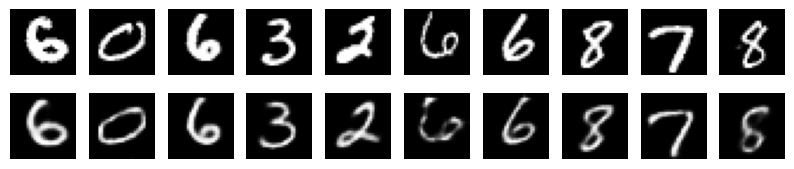

In [104]:
display_results(predictions_vae, X_test, n=10)

In [98]:
vae_model.save('vae_model.h5')
#del vae_model
#gc.collect()
#vae_model = load_model('vae_model.h5')

In [105]:
#vae_model = load_model('vae_model.h5')

In [ ]:
np.linalg.eig()